# MBTI Personality Prediction 

## Basic Imports

### `Data Preprocessing Libraries`

In [86]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from tqdm import tqdm # Used for creating progress bars in python codes
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import re
import string
from nltk.stem.porter import PorterStemmer


### `Machine Learning Models`

In [55]:
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier

### `Libraries for evaluating Model`

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE

## Loading the dataset

In [57]:
data = pd.read_csv('mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [58]:
data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'I broke the windshield. With my foot. When ...
freq,1832,1


In [19]:
# There are 16 different personalities
len(data['type'].value_counts()) , data['type'].value_counts()


(16,
 INFP    1832
 INFJ    1470
 INTP    1304
 INTJ    1091
 ENTP     685
 ENFP     675
 ISTP     337
 ISFP     271
 ENTJ     231
 ISTJ     205
 ENFJ     190
 ISFJ     166
 ESTP      89
 ESFP      48
 ESFJ      42
 ESTJ      39
 Name: type, dtype: int64)

### Checking for duplicates and NaN values

In [22]:
data.duplicated().sum(), data.isna().sum()
# No duplicates and NaN values found

(0,
 type     0
 posts    0
 dtype: int64)

In [26]:
def clean_text(data):
    data_length=[]
    lemmatizer = WordNetLemmatizer()
    cleaned_text=[]
    
    for sentence in tqdm(data.posts):
        sentence = sentence.lower()
        
        #removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
        #removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return clean_text, data_length

In [61]:
encoder = LabelEncoder()
data['type'] = encoder.fit_transform(data['type'])

In [64]:
data,dict(zip(encoder.classes_,range(len(encoder.classes_))))

(      type                                              posts
 0        8  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
 1        3  'I'm finding the lack of me in these posts ver...
 2       11  'Good one  _____   https://www.youtube.com/wat...
 3       10  'Dear INTP,   I enjoyed our conversation the o...
 4        2  'You're fired.|||That's another silly misconce...
 ...    ...                                                ...
 8670    13  'https://www.youtube.com/watch?v=t8edHB_h908||...
 8671     1  'So...if this thread already exists someplace ...
 8672    11  'So many questions when i do these things.  I ...
 8673     9  'I am very conflicted right now when it comes ...
 8674     9  'It has been too long since I have been on per...
 
 [8675 rows x 2 columns],
 {'ENFJ': 0,
  'ENFP': 1,
  'ENTJ': 2,
  'ENTP': 3,
  'ESFJ': 4,
  'ESFP': 5,
  'ESTJ': 6,
  'ESTP': 7,
  'INFJ': 8,
  'INFP': 9,
  'INTJ': 10,
  'INTP': 11,
  'ISFJ': 12,
  'ISFP': 13,
  'ISTJ': 14,
  'ISTP': 15})

In [65]:
nltk.download('punkt') 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrity\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [89]:
ps = PorterStemmer()
def transfrom_text(text):
    text = text.lower()
    text=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',text)
    text = nltk.word_tokenize(text)
    ls = []
    for word in text:
        if word .isalnum():
            ls.append(word)
    text = ls[:]
    ls.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            ls.append(i)
    text = ls[:]
    ls.clear()
    
    for i in text:
        ls.append(ps.stem(i))
    
    return " ".join(ls)

In [90]:
transfrom_text(data['posts'][0])

'intj moment sportscent top ten play experi life repeat perc experi immers last thing infj friend post facebook commit suicid next day rest enfj7 sorri hear distress natur relationship perfect time everi moment exist tri figur hard time time growth 84390 game set wellbrutin least thirti minut move leg mean move sit desk chair weed moder mayb tri edibl healthier altern come three item determin type whichev type want would like use given type cognit function whatnot left thing moder sim inde video game good one note good one somewhat subject complet promot death given sim enfp favorit video game grow current favorit video game cool appear late sad someon thought confid good cherish time solitud revel within inner world wherea time workin enjoy time worri peopl alway around entp ladi complimentari person well main social outlet xbox live convers even verbal fatigu realli dig part thread requir high backyard roast eat marshmellow backyard convers someth intellectu follow massag mani b sent

In [91]:
data['transfromed_text'] = data['posts'].apply(transfrom_text)

In [92]:
data

,type,posts,transfromed_text
0,8,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moment sportscent top ten play experi lif...
1,3,'I'm finding the lack of me in these posts ver...,find lack post bore posit often exampl girlfri...
2,11,'Good one _____ https://www.youtube.com/wat...,one cours say know bless absolut posit best fr...
3,10,"'Dear INTP, I enjoyed our conversation the o...",intp enjoy convers day esoter gab natur univer...
4,2,'You're fired.|||That's another silly misconce...,anoth silli misconcept approach logic go key u...
...,...,...,...
8670,13,'https://www.youtube.com/watch?v=t8edHB_h908||...,alway think cat fi dom reason websit becom neo...
8671,1,'So...if this thread already exists someplace ...,thread alreadi exist someplac els heck delet o...
8672,11,'So many questions when i do these things. I ...,mani question thing would take purpl pill pick...
8673,9,'I am very conflicted right now when it comes ...,conflict right come want children honestli mat...


In [98]:
data.rename({'transfromed_text':'transformed_text'},axis=1,inplace=True)

In [99]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [103]:
ENFP = wc.generate(data[data['type'] == 1]['transformed_text'].str.cat(sep=" "))


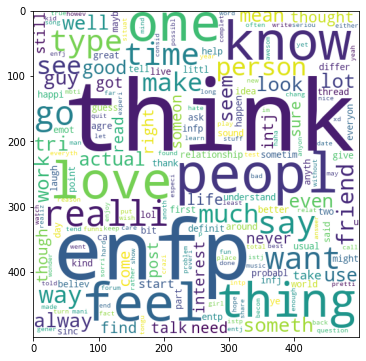

In [104]:
plt.figure(figsize=(15,6),facecolor='white')
plt.imshow(ENFP)

In [129]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [130]:
X = tfidf.fit_transform(data['transformed_text']).toarray()

In [107]:
X.shape

(8675, 3000)

In [108]:
y = data['type'].values

In [110]:
y

array([ 8,  3, 11, ..., 11,  9,  9])

In [111]:
from sklearn.model_selection import train_test_split

In [112]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [113]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [114]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [116]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [117]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [120]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average=None,pos_label='positive')
    
    return accuracy,precision

In [121]:
train_classifier(svc,X_train,y_train,X_test,y_test)

c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6426512968299711,
 array([0.73333333, 0.66019417, 0.54054054, 0.74336283, 0.6       ,
        0.        , 1.        , 0.28571429, 0.59281437, 0.64646465,
        0.62085308, 0.68571429, 0.7       , 0.6       , 0.55172414,
        0.67272727]))

In [122]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For  SVC
Accuracy -  0.6426512968299711
Precision -  [0.73333333 0.66019417 0.54054054 0.74336283 0.6        0.
 1.         0.28571429 0.59281437 0.64646465 0.62085308 0.68571429
 0.7        0.6        0.55172414 0.67272727]


c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For  KN
Accuracy -  0.40172910662824207
Precision -  [0.04545455 0.29949239 0.34146341 0.45794393 0.1875     0.33333333
 0.5        0.33333333 0.47301587 0.37647059 0.7        0.64634146
 0.6        0.54545455 0.42857143 0.30985915]
For  NB
Accuracy -  0.3861671469740634
Precision -  [0.         0.8        0.         0.33333333 0.         0.
 0.         0.         0.36910995 0.3560529  0.61111111 0.44947735
 0.         0.         0.         0.        ]


c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For  DT
Accuracy -  0.5118155619596542
Precision -  [0.         0.55371901 0.         0.6        0.         0.
 0.         0.         0.63669065 0.40661939 0.62874251 0.60431655
 0.         0.         0.         0.        ]


c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


For  LR
Accuracy -  0.6547550432276658
Precision -  [0.7        0.64814815 0.51612903 0.73043478 0.5        1.
 0.5        0.4        0.64968153 0.65338645 0.66359447 0.66449511
 0.73333333 0.55172414 0.57142857 0.62962963]


c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For  RF
Accuracy -  0.5072046109510087
Precision -  [0.         0.61333333 0.66666667 0.71641791 0.         0.
 0.         0.         0.44811321 0.48865356 0.54651163 0.52664577
 0.         0.5        0.         1.        ]


c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


For  AdaBoost
Accuracy -  0.34755043227665705
Precision -  [0.51851852 0.44444444 0.33333333 0.18181818 0.33333333 0.
 0.23529412 0.2        0.21914358 0.65714286 0.07936508 0.2037037
 0.66666667 0.34285714 0.31578947 0.47945205]


c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For  BgC
Accuracy -  0.6184438040345821
Precision -  [0.57142857 0.56737589 0.52380952 0.68807339 0.         0.
 0.         0.33333333 0.60191083 0.63545817 0.65326633 0.62416107
 0.71428571 0.52941176 0.42307692 0.59649123]


c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got None). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\mrity\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For  ETC
Accuracy -  0.4144092219020173
Precision -  [0.         0.6        0.66666667 0.6        0.         0.
 0.         0.         0.36666667 0.39696587 0.45070423 0.4532872
 0.         0.         0.         0.75      ]


KeyboardInterrupt: 

In [123]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores}).sort_values('Accuracy',ascending=False)


ValueError: arrays must all be same length

In [ ]:
performance_df

In [ ]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [ ]:
performance_df1

In [124]:
import pickle
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(svc,open('model.pkl','wb'))

In [137]:
# data['transformed_text'][0]
# vectorized
svc.predict(X_test)

array([ 8,  9,  8, ...,  9, 10, 15])